In [107]:
# #!pip install pandas numpy scikit-learn imbalanced-learn matplotlib seaborn colorcet concurrent futures
# !pip install scikit-learn
# !pip install scikit-plot
# !pip install imblearn
# !pip install colorcet
# !pip install scipy
# !pip install pandas
# !pip install Pillow
# !pip install imutils
# !pip install joblib
# !pip install jupyter
# !pip install jupyter-client
# !pip install jupyter_contrib_nbextensions
# !pip install seaborn
# !pip install matplotlib
# !pip install flask

In [108]:

# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
import colorcet as cc
from sklearn.manifold import TSNE
import os
import joblib
import concurrent.futures

seed = 42

In [109]:
# Load and display data
original_data = pd.read_csv("DATA_SET.csv")
data = original_data.copy()

display(data.shape)
data.head(3)

(48307, 79)

,Name,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,e_sp,...,SectionMainChar,DirectoryEntryImport,DirectoryEntryImportSize,DirectoryEntryExport,ImageDirectoryEntryExport,ImageDirectoryEntryImport,ImageDirectoryEntryResource,ImageDirectoryEntryException,ImageDirectoryEntrySecurity,Category
0,P2P-Worm.Win32.Palevo.bhnc-ad71644f5eb93992d8d...,23117,144,3,0,4,0,65535,0,184,...,1073741888,114,8,0,0,109300,0,0,0,Worms
1,P2P-Worm.Win32.Palevo.bhnc-add453e0e5524422976...,23117,144,3,0,4,0,65535,0,184,...,1073741888,101,6,0,0,75628,94208,0,0,Worms
2,P2P-Worm.Win32.Palevo.bhnc-ae211cabadf6e25affa...,23117,144,3,0,4,0,65535,0,184,...,1073741888,150,10,0,0,124036,0,0,0,Worms


Number of duplicate rows: 13646
Number of duplicate rows after removal: 0


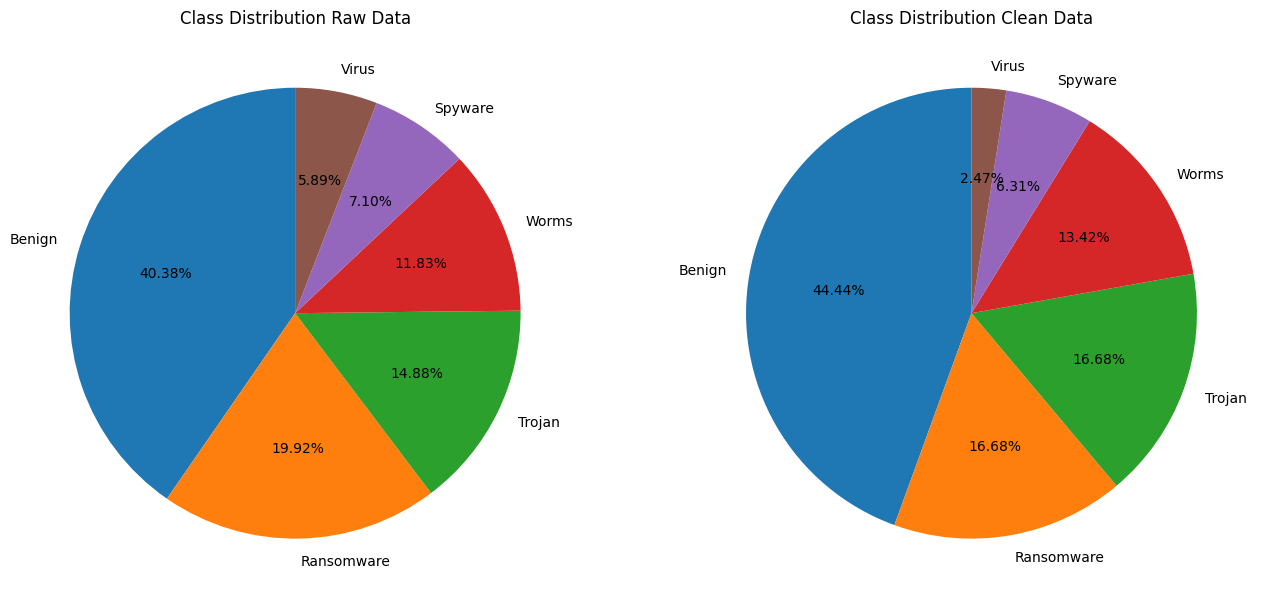

In [110]:

# Drop the 'Name' column
data = data.drop('Name', axis=1)

# Removing duplicate Rows
duplicate_rows = data.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())
data.drop_duplicates(inplace=True)
print("Number of duplicate rows after removal:", data.duplicated().sum())

target = data['Category']
data = data.drop('Category', axis=1)

# Drop columns with standard deviation of 0
data = data.drop(labels=data.loc[:, data.std() == 0].columns, axis=1)
data = pd.concat([data, target], axis=1)
data.to_csv('Cleandata.csv', index=False)

# Load clean data and encode labels
data = pd.read_csv("Cleandata.csv")
label_encoder = LabelEncoder()
data['Category'] = label_encoder.fit_transform(data['Category'])
class_names = label_encoder.classes_

# Data visualization
categories = ['Benign', 'Ransomware', 'Trojan', 'Worms', 'Spyware', 'Virus']
Values0 = original_data['Category'].value_counts()
Values1 = data['Category'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for Raw Data
axes[0].pie(Values0, labels=categories, autopct='%1.2f%%', startangle=90)
axes[0].set_title('Class Distribution Raw Data')

# Plot for Clean Data
axes[1].pie(Values1, labels=categories, autopct='%1.2f%%', startangle=90)
axes[1].set_title('Class Distribution Clean Data')

# Save the combined figure
plt.savefig("Class_Distribution_Comparison")
plt.show()


In [111]:

# Adjust for dataset 0.5 = 50%   and 1 = 100% 
Adjust = 0.5
data = data.groupby('Category').sample(frac=Adjust, random_state=seed)
print(data.shape)
Pernt = int(Adjust*100)

# Separate features and target
X = data.drop('Category', axis=1)
y = data['Category']



(17329, 76)


In [112]:
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Create directories for saving results
base_output_dir = f'Evaluation_Results_{Pernt}%'
create_directory(base_output_dir)


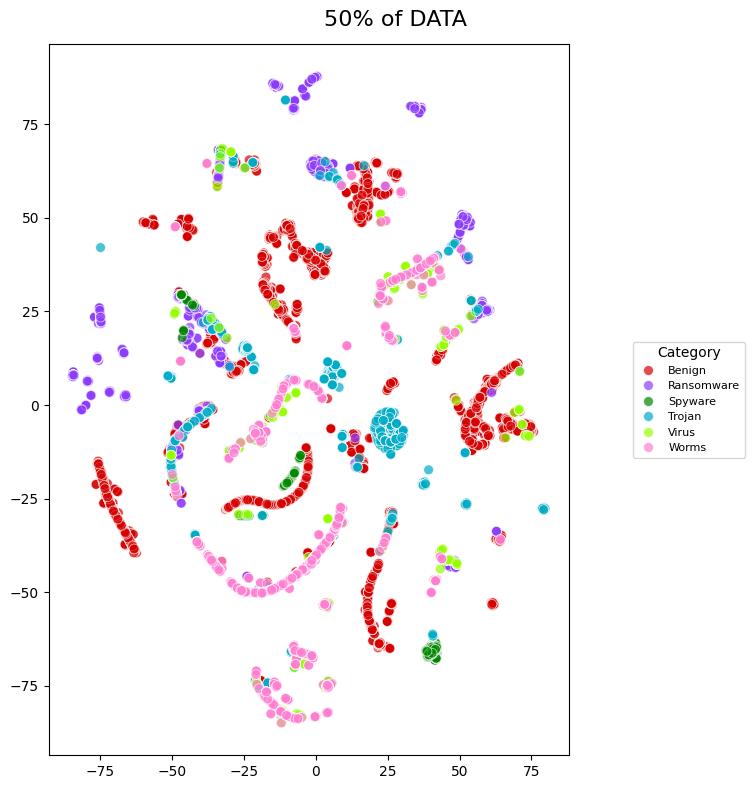

In [113]:

# Visualization
pipeline_tsne = Pipeline([
    ("tsne", TSNE(n_components=2, learning_rate="auto", init="random", perplexity=100, random_state=0))
])

x_visualize = pipeline_tsne.fit_transform(data)

n_categories = len(np.unique(y))
palette = sns.color_palette(cc.glasbey, n_categories)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x=x_visualize[:, 0], y=x_visualize[:, 1], hue=y, palette=palette, s=50, alpha=0.7, legend='full', ax=ax)
handles, labels = ax.get_legend_handles_labels()  # Get legend handles and labels from the ax object
ax.legend(handles, class_names, title='Category', loc="center right", bbox_to_anchor=(1.35, 0.5), prop={"size": 8})

fig.suptitle(f"{Pernt}% of DATA", fontsize=16)
plt.tight_layout()
output_file = os.path.join(base_output_dir, "Scatterplot.png")
plt.savefig(output_file)
plt.show()



In [114]:
# Define feature selection functions
def select_info_gain(X, y, num_features=15):
    info_gain = mutual_info_classif(X, y, random_state=seed)
    indices = np.argsort(info_gain)[-num_features:]
    return X.iloc[:, indices]

def select_permutation_importance(X, y, num_features=15):
    model = RandomForestClassifier(random_state=seed)
    model.fit(X, y)
    perm_importance = permutation_importance(model, X, y, random_state=seed)
    indices = np.argsort(perm_importance.importances_mean)[-num_features:]
    return X.iloc[:, indices]

def select_correlation_coefficient(X, y, num_features=15):
    data_with_target = pd.concat([X, y], axis=1)
    correlation_matrix = data_with_target.corr()
    correlation_with_target = correlation_matrix['Category'].drop('Category')
    indices = np.argsort(correlation_with_target.abs())[-num_features:]
    return X.iloc[:, indices]

# Initialize dictionary to hold selected features
selected_features = {}

# Apply feature selection methods
selected_features['Info Gain']= select_info_gain(X, y)
selected_features['Permutation Importance']= select_permutation_importance(X, y)
selected_features['Correlation Coefficient'] = select_correlation_coefficient(X, y)


In [115]:

# Function to combine features and deduplicate
def combine_features(selected_features):
    combined_features = pd.concat(selected_features.values(), axis=1)
    # Remove duplicate columns (by feature names)
    combined_features = combined_features.loc[:, ~combined_features.columns.duplicated()]
    return combined_features

# Final combined dataset with deduplicated features
final_datasets = combine_features(selected_features)

In [121]:
final_datasets.shape

(17329, 32)

In [116]:
# Function to compare feature frequency across datasets
def compare_and_print_features(selected_features):
    # Extract feature names from each dataset and track frequency of occurrence
    feature_frequency = {}
    for method, df in selected_features.items():
        for feature in df.columns:
            if feature in feature_frequency:
                feature_frequency[feature] += 1
            else:
                feature_frequency[feature] = 1

    # Identify features based on frequency
    all_methods = len(selected_features)
    common_features = [feature for feature, count in feature_frequency.items() if count == all_methods]
    unique_features = [feature for feature, count in feature_frequency.items() if count == 1]

    # Print results
    print(f"Total number of features selected: {len(feature_frequency)}\n")
    
    # Common features appearing in all methods
    print(f"Common features (appear in all {all_methods} methods): {len(common_features)}")
    print(*sorted(common_features), sep='\n')

    # Unique features appearing only in one method
    print(f"\nUnique features (appear in only one method): {len(unique_features)}")
    print(*sorted(unique_features), sep='\n')

    # Features and their frequency across selection methods
    print("\nFeature frequencies across methods:")
    for feature, count in feature_frequency.items():
        print(f"{feature}: {count} method(s)")

# Call the function with the selected features
compare_and_print_features(selected_features)


Total number of features selected: 32

Common features (appear in all 3 methods): 1
SectionMaxEntropy

Unique features (appear in only one method): 20
CheckSum
FileAlignment
ImageDirectoryEntryImport
ImageDirectoryEntrySecurity
Machine
Magic
MajorLinkerVersion
MajorSubsystemVersion
MinorLinkerVersion
NumberOfSections
SectionMainChar
SectionMaxPhysical
SectionMaxPointerData
SectionMaxVirtualsize
SectionsLength
SizeOfCode
SizeOfHeaders
SizeOfImage
SizeOfInitializedData
SizeOfOptionalHeader

Feature frequencies across methods:
SizeOfImage: 1 method(s)
SectionMinEntropy: 2 method(s)
SizeOfInitializedData: 1 method(s)
Characteristics: 2 method(s)
SectionMaxEntropy: 3 method(s)
SectionMaxPointerData: 1 method(s)
SectionMaxRawsize: 2 method(s)
SizeOfCode: 1 method(s)
ImageDirectoryEntryImport: 1 method(s)
SectionMaxPhysical: 1 method(s)
SectionMaxVirtualsize: 1 method(s)
AddressOfEntryPoint: 2 method(s)
SectionMinPhysical: 2 method(s)
SectionMinVirtualsize: 2 method(s)
TimeDateStamp: 2 method

In [11]:
# Random Forest parameters
param_grid =  {
        'n_estimators': [100, 200, 300],
        'max_features': ['sqrt', 'log2'],
        'max_depth': range(10, 120, 10),
        'min_samples_split': [2, 6, 10],
        'min_samples_leaf': [1, 3, 4],
        'bootstrap': [True, False]
    }


In [12]:

# Evaluation method
def evaluate_model(model, X_test, y_test, dataset_name, ax_roc=None, ax_cm=None):
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    
    metrics = {
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'Accuracy': accuracy_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_score, multi_class='ovo')
    }
    
    # Plot ROC curve
    if ax_roc is not None:
        for i in range(len(np.unique(y_test))):
            fpr, tpr, _ = roc_curve(y_test == i, y_score[:, i])
            roc_auc = auc(fpr, tpr)
            ax_roc.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')
        ax_roc.set_xlabel('False Positive Rate')
        ax_roc.set_ylabel('True Positive Rate')
        ax_roc.set_title(f'Random Forest ROC Curve - {dataset_name}')
        ax_roc.legend(loc='lower right')

    # Plot confusion matrix
    if ax_cm is not None:
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(ax=ax_cm, xticks_rotation='vertical', cmap='Blues')
        ax_cm.set_title(f'Random Forest Confusion Matrix - {dataset_name}')
    
    return metrics


In [13]:

# Evaluate datasets in parallel
def evaluate_dataset(X_data, output_dir):
    results = {}
    best_estimates = []

    X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.3, random_state=seed, stratify=y)

    for smote_status in ['No SMOTE', 'SMOTE']:
        if smote_status == 'SMOTE':
            smote = SMOTE(random_state=seed)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        else:
            X_train_resampled, y_train_resampled = X_train, y_train

        # Train and tune Random Forest
        rf = RandomForestClassifier(random_state=seed)
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=seed)
        grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)
        best_model = grid_search.best_estimator_

        # Best Parameters
        best_ensemble = grid_search.best_params_
        best_estimates.append({
            'SMOTE Status': smote_status,
            'Best Parameters': best_ensemble,
            'Best Score': grid_search.best_score_
        })

        # Save model
        model_filename = f"{output_dir}/RF_{smote_status}.pkl"
        joblib.dump(best_model, model_filename)

        # Create plots
        fig, (ax_roc, ax_cm) = plt.subplots(1, 2, figsize=(15, 6))
        metrics = evaluate_model(best_model, X_test, y_test, smote_status, ax_roc, ax_cm)

        # Save plots
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'RF_metrics_{smote_status}.png'))
        plt.close()

        results[smote_status] = metrics

    # Save best parameters to CSV
    best_params_df = pd.DataFrame(best_estimates)
    best_params_df.to_csv(os.path.join(output_dir, 'best_parameters.csv'), index=False)

    return results

In [14]:

# Initialize dictionary to collect results
final_results = {}

# Ensure the output directory exists
final_output_dir = os.path.join(base_output_dir, 'final_datasets')
create_directory(final_output_dir)
# Evaluate the combined final dataset
results = evaluate_dataset(final_datasets, final_output_dir)

# Save results
results_df = pd.DataFrame(results).T
output_file = os.path.join(final_output_dir, 'final_dataset_results.csv')
results_df.to_csv(output_file, index=True)
# Store the results in final_results for further use if needed
final_results['final_dataset'] = results


C:\Users\g23m8231\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\g23m8231\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [15]:
# Initialize dictionary to collect all feature selection results
feature_selection_results = {}
# Evaluate individual feature selection datasets
for method_name, features_df in selected_features.items():
    # Create method-specific output directory
    method_output_dir = os.path.join(base_output_dir, f'feature_selection_{method_name}')
    create_directory(method_output_dir)
    
    # Evaluate the dataset
    results = evaluate_dataset(features_df, method_output_dir)
    
    # Save the results to CSV
    results_df = pd.DataFrame(results).T
    output_file = os.path.join(method_output_dir, f'{method_name}_results.csv')
    results_df.to_csv(output_file, index=True)
    
    # Store the results in feature_selection_results
    feature_selection_results[method_name] = results

# Save overall feature selection results summary
feature_selection_summary = {}
for method_name, results in feature_selection_results.items():
    for smote_status, metrics in results.items():
        key = f"{method_name}_{smote_status}"
        feature_selection_summary[key] = metrics

summary_df = pd.DataFrame(feature_selection_summary).T
summary_df.to_csv(os.path.join(base_output_dir, 'feature_selection_summary.csv'))

C:\Users\g23m8231\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\g23m8231\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\g23m8231\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\g23m8231\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered i